In [13]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

In [14]:
# Загрузка данных
train_df = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')

print(f"Размер датасета: {train_df.shape}")
print(f"\nПервые строки:")
train_df.head()


Размер датасета: (517754, 14)

Первые строки:


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [15]:
# Информация о данных
print("Информация о данных:")
print(train_df.info())
print("\nСтатистика:")
print(train_df.describe())
print("\nПропущенные значения:")
print(train_df.isnull().sum())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtyp

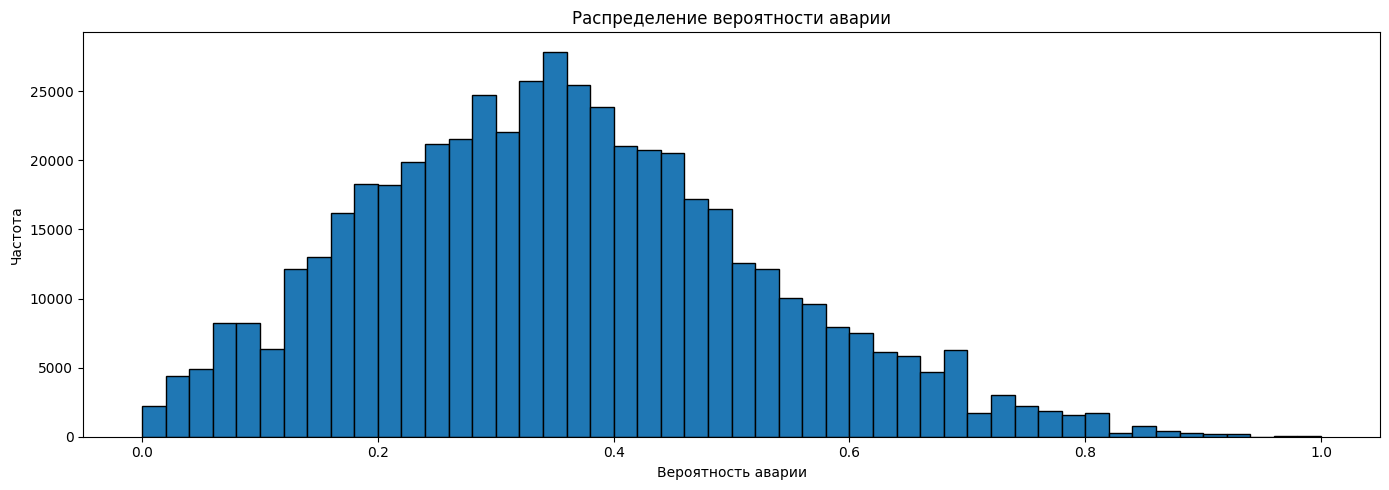

Минимум: 0.0
Максимум: 1.0
Среднее: 0.3524


In [16]:
# Анализ целевой переменной
fig, axes = plt.subplots(1, 1, figsize=(14, 5))

axes.hist(train_df['accident_risk'], bins=50, edgecolor='black')
axes.set_title('Распределение вероятности аварии')
axes.set_xlabel('Вероятность аварии')
axes.set_ylabel('Частота')

plt.tight_layout()
plt.show()

print(f"Минимум: {train_df['accident_risk'].min()}")
print(f"Максимум: {train_df['accident_risk'].max()}")
print(f"Среднее: {train_df['accident_risk'].mean():.4f}")


In [17]:
# Разделение на признаки и целевую переменную
X = train_df.drop(['id', 'accident_risk'], axis=1)
y = train_df['accident_risk']

print("Типы признаков:")
print(X.dtypes)
print("\nКатегориальные признаки:")
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
print(categorical_features)
print("\nЧисловые признаки:")
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)


Типы признаков:
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
dtype: object

Категориальные признаки:
['road_type', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season']

Числовые признаки:
['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']


In [18]:
# Кодирование категориальных признаков
X_encoded = X.copy()

# Label Encoding для категориальных признаков
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {le.classes_}")

print("\nПосле кодирования:")
print(X_encoded.head())
print(f"\nРазмер: {X_encoded.shape}")


road_type: ['highway' 'rural' 'urban']
lighting: ['daylight' 'dim' 'night']
weather: ['clear' 'foggy' 'rainy']
road_signs_present: ['False' 'True']
public_road: ['False' 'True']
time_of_day: ['afternoon' 'evening' 'morning']
holiday: ['False' 'True']
school_season: ['False' 'True']

После кодирования:
   road_type  num_lanes  curvature  speed_limit  lighting  weather  \
0          2          2       0.06           35         0        2   
1          2          4       0.99           35         0        0   
2          1          4       0.63           70         1        0   
3          0          4       0.07           35         1        2   
4          1          1       0.58           60         0        1   

   road_signs_present  public_road  time_of_day  holiday  school_season  \
0                   0            1            0        0              1   
1                   1            0            1        1              1   
2                   0            1            2    

In [19]:
# Разделение на train и validation
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Train размер: {X_train.shape}")
print(f"Validation размер: {X_val.shape}")


Train размер: (414203, 12)
Validation размер: (103551, 12)


In [34]:
# # Обучение XGBoost Regressor
# model = xgb.XGBRegressor(
#     n_estimators=2000,
#     max_depth=6,
#     learning_rate=0.005,
#     random_state=42,
#     n_jobs=-1
# )

# print("Начало обучения модели...")
# model.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_val, y_val)],
#     verbose=10,
#     early_stopping_rounds=40
# )
# print("\nОбучение завершено!")


Начало обучения модели...
[0]	validation_0-rmse:0.16575	validation_1-rmse:0.16545


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.15867	validation_1-rmse:0.15840
[20]	validation_0-rmse:0.15198	validation_1-rmse:0.15173
[30]	validation_0-rmse:0.14567	validation_1-rmse:0.14544
[40]	validation_0-rmse:0.13970	validation_1-rmse:0.13950
[50]	validation_0-rmse:0.13408	validation_1-rmse:0.13390
[60]	validation_0-rmse:0.12878	validation_1-rmse:0.12863
[70]	validation_0-rmse:0.12378	validation_1-rmse:0.12365
[80]	validation_0-rmse:0.11908	validation_1-rmse:0.11898
[90]	validation_0-rmse:0.11466	validation_1-rmse:0.11458
[100]	validation_0-rmse:0.11051	validation_1-rmse:0.11044
[110]	validation_0-rmse:0.10661	validation_1-rmse:0.10656
[120]	validation_0-rmse:0.10294	validation_1-rmse:0.10292
[130]	validation_0-rmse:0.09951	validation_1-rmse:0.09950
[140]	validation_0-rmse:0.09630	validation_1-rmse:0.09631
[150]	validation_0-rmse:0.09330	validation_1-rmse:0.09332
[160]	validation_0-rmse:0.09049	validation_1-rmse:0.09053
[170]	validation_0-rmse:0.08787	validation_1-rmse:0.08793
[180]	validation_0-rmse

In [44]:
# Усложненная модель
model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=8,           
    learning_rate=0.05,   
    
    # Умеренная регуляризация
    reg_alpha=0.01,
    reg_lambda=0.1,
    gamma=0.01,
    
    # Оптимальное сэмплирование
    subsample=0.9,
    colsample_bytree=0.9,
    
    # Простые настройки
    min_child_weight=1,
    tree_method='hist',
    
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("Начало обучения модели...")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=10
)
print("\nОбучение завершено!")


Начало обучения модели...
[0]	validation_0-rmse:0.16119	validation_1-rmse:0.16092
[10]	validation_0-rmse:0.10986	validation_1-rmse:0.10983
[20]	validation_0-rmse:0.08620	validation_1-rmse:0.08637
[30]	validation_0-rmse:0.07219	validation_1-rmse:0.07251
[40]	validation_0-rmse:0.06376	validation_1-rmse:0.06418
[50]	validation_0-rmse:0.05911	validation_1-rmse:0.05961
[60]	validation_0-rmse:0.05745	validation_1-rmse:0.05801
[70]	validation_0-rmse:0.05642	validation_1-rmse:0.05701
[80]	validation_0-rmse:0.05597	validation_1-rmse:0.05659
[90]	validation_0-rmse:0.05574	validation_1-rmse:0.05638
[100]	validation_0-rmse:0.05561	validation_1-rmse:0.05628
[110]	validation_0-rmse:0.05554	validation_1-rmse:0.05623
[120]	validation_0-rmse:0.05551	validation_1-rmse:0.05621
[130]	validation_0-rmse:0.05549	validation_1-rmse:0.05620
[140]	validation_0-rmse:0.05548	validation_1-rmse:0.05619
[150]	validation_0-rmse:0.05547	validation_1-rmse:0.05619
[160]	validation_0-rmse:0.05546	validation_1-rmse:0.05619

In [45]:
# Предсказания
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Оценка модели
print("МЕТРИКИ НА TRAIN:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.6f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.6f}")
print(f"R2 Score: {r2_score(y_train, y_train_pred):.6f}")

print("МЕТРИКИ НА VALIDATION:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.6f}")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.6f}")
print(f"R2 Score: {r2_score(y_val, y_val_pred):.6f}")


МЕТРИКИ НА TRAIN:
RMSE: 0.055439
MAE: 0.043169
R2 Score: 0.889102
МЕТРИКИ НА VALIDATION:
RMSE: 0.056184
MAE: 0.043605
R2 Score: 0.885678


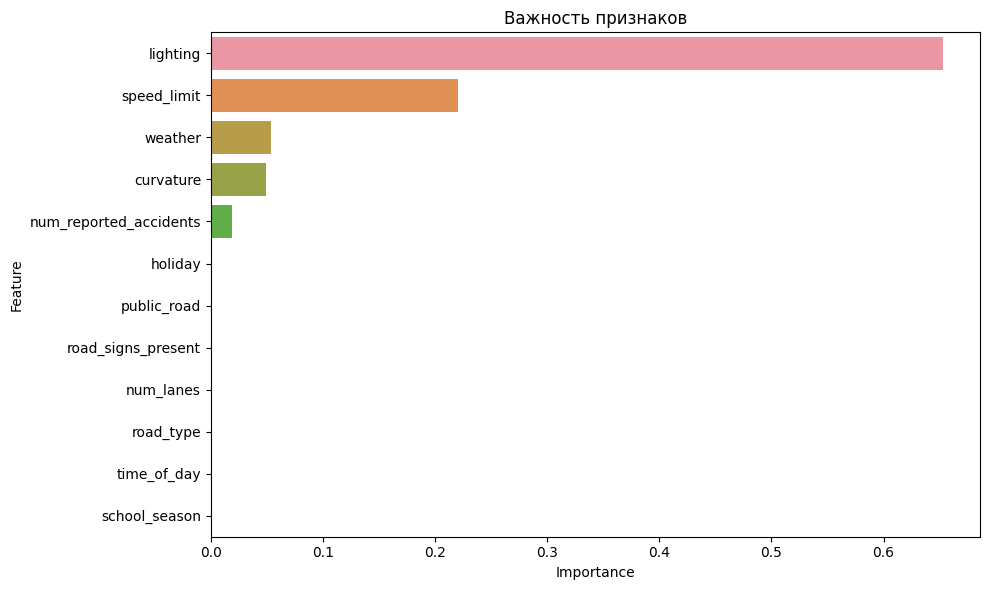


Топ-10 наиболее важных признаков:
                   feature  importance
4                 lighting    0.653347
3              speed_limit    0.220363
5                  weather    0.053670
2                curvature    0.049332
11  num_reported_accidents    0.019046
9                  holiday    0.001444
7              public_road    0.001053
6       road_signs_present    0.000419
1                num_lanes    0.000415
0                road_type    0.000355


In [46]:
# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Важность признаков')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nТоп-10 наиболее важных признаков:")
print(feature_importance.head(10))


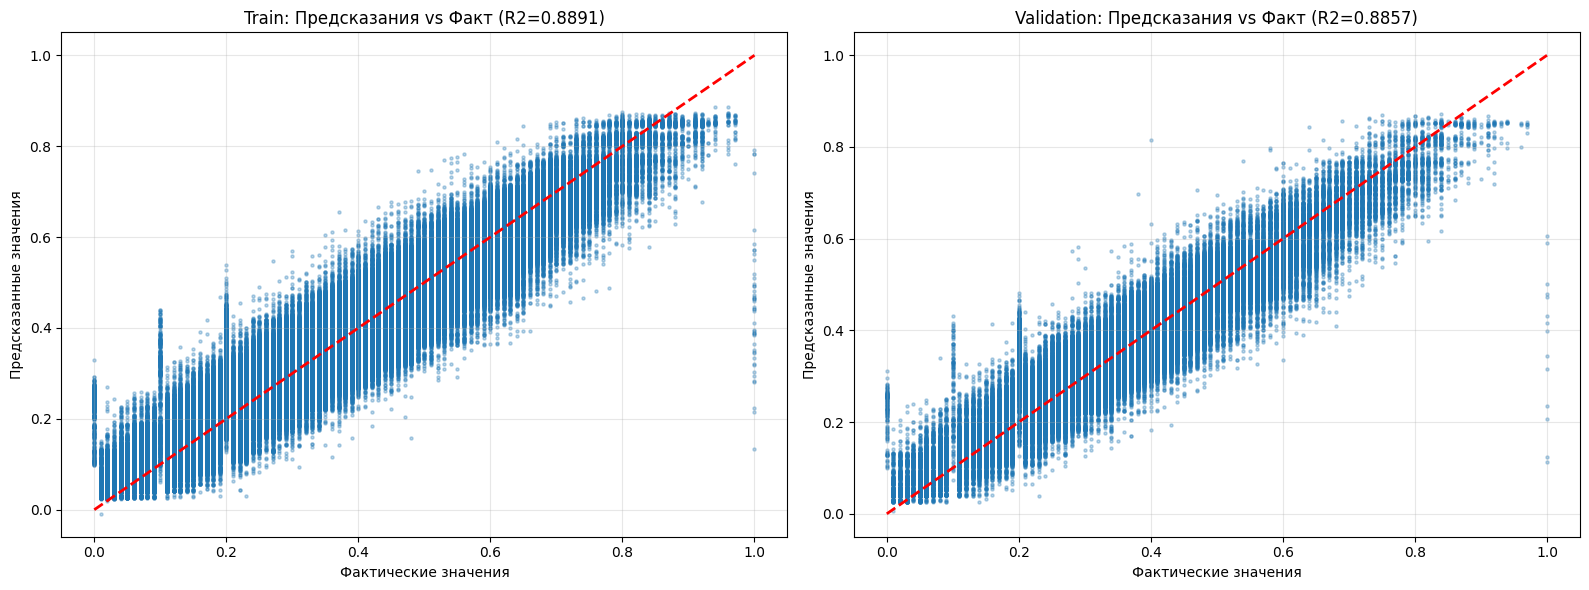

In [47]:
# Визуализация предсказаний
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.3, s=5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Фактические значения')
axes[0].set_ylabel('Предсказанные значения')
axes[0].set_title(f'Train: Предсказания vs Факт (R2={r2_score(y_train, y_train_pred):.4f})')
axes[0].grid(True, alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.3, s=5)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Фактические значения')
axes[1].set_ylabel('Предсказанные значения')
axes[1].set_title(f'Validation: Предсказания vs Факт (R2={r2_score(y_val, y_val_pred):.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Загрузка тестовых данных и предсказание (если есть test.csv)
try:
    test_df = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
    print(f"Тестовый набор загружен: {test_df.shape}")
    
    # Сохраняем ID
    test_ids = test_df['id']
    
    # Подготовка тестовых данных
    X_test = test_df.drop(['id'], axis=1)
    
    # Кодирование категориальных признаков
    X_test_encoded = X_test.copy()
    for col in categorical_features:
        if col in X_test_encoded.columns:
            X_test_encoded[col] = label_encoders[col].transform(X_test_encoded[col].astype(str))
    
    # Предсказания
    test_predictions = model.predict(X_test_encoded)
    
    # Создание submission файла
    submission = pd.DataFrame({
        'id': test_ids,
        'accident_risk': test_predictions
    })
    
    submission.to_csv('submission.csv', index=False)
    print("\nПредсказания сохранены в submission.csv")
    
    print(f"\nПервые строки submission:")
    print(submission.head(10))
    print(f"\nСтатистика предсказаний:")
    print(submission['accident_risk'].describe())
    
except FileNotFoundError:
    print("Файл test.csv не найден. Пропускаем создание submission.")
